# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
сalls — количество звонков,  
minutes — суммарная длительность звонков в минутах,  
messages — количество sms-сообщений,  
mb_used — израсходованный интернет-трафик в Мб,  
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика    

**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  


Мы видим, что у тарифов разная суммарная длительность звонков, разное кол-во сообщений, и разный израсходованный интернет-трафик, т.е. столбец кол-во звонков нам погоды не сделает, он не нужен.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_iris
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

import numpy as np
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('users_behavior.csv')
display(data.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


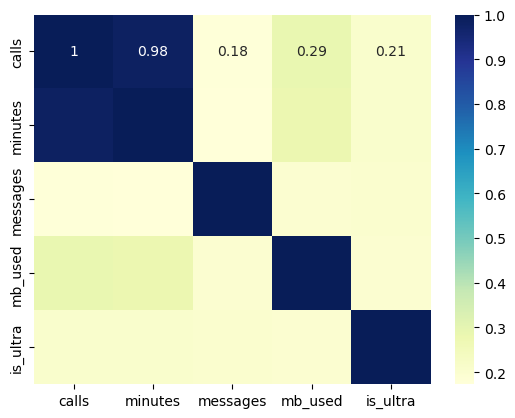

In [3]:
data_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  
plt.show()

Получается calls и minutes имеет одниаковую корреляцию с is_ultra. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

     Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата. Когда независимые переменные коррелируют друг с другом, говорят о возникновении мультиколлинеарности.
В машинном обучении мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. 
    
*Различные способы решения проблемы мультиколлинеарности:*
- Выбор переменных. Переменные следует выбирать таким образом, чтобы те, которые сильно коррелированы, были удалены, и мы использовали только значимые переменные.
- Преобразование переменных. Преобразование переменных является неотъемлемым шагом, и здесь цель состоит в том, чтобы сохранить функцию, но выполнение преобразования может дать нам диапазон, который не приведет к предвзятому результату.
- Анализ главных компонентов. Анализ основных компонентов — это метод уменьшения размерности, с помощью которого мы можем получить важные характеристики набора данных, которые сильно влияют на нашу целевую переменную.   
    
*Какие проблемы могут возникнуть из-за мультиколлинеарности?* Поскольку существует сильная взаимосвязь, определение значимых переменных будет сложной задачей. Коэффициенты, которые мы получим для переменных, могут быть нестабильными, и, как следствие, интерпретация модели будет утомительной работой. Может произойти переобучение, и точность модели изменится в зависимости от набора данных.  

Это все для регрессионной модели.



## Разбейте данные на выборки

Мы разделим данные на обучающую (60%), валидационную (20%) и тестовую выборки(20%).

Сохраним признаки в отдельных переменных:

In [6]:
data_train, data_test1 = train_test_split(data, test_size=0.4, random_state=12345, stratify=data['is_ultra']) 
data_test, data_valid = train_test_split(data_test1, test_size=0.5, random_state=12345) #stratify=data['is_ultra']) 
print(data_train.shape)
print(data_test.shape)
print(data_valid.shape)

(1928, 5)
(643, 5)
(643, 5)


## Исследуйте модели

Так как нам нужно построить модель для задачи классификации, которая выберет подходящий тариф, то столбец "is_ultra" - это наш ответ (целевой признак), и это бинарная классификация (категориальный целевой признак).  

Модель мы тренируем на тренировочной(обучающей), оцениваем качество на валидационной. А тестовая просто для контроля. Если очень большие расхождения между валидационной и тестовой - переделываем алгоритм.

Мы обучим дерево решений, случайный лес и логистическую регрессию. 

In [7]:
#features = pd.DataFrame(data=data, columns=['minutes', 'messages', 'mb_used'])
features = data.drop(['calls', 'is_ultra'], axis=1)
target = data['is_ultra']
print(features.shape)
print(target.shape)

(3214, 3)
(3214,)


In [9]:
#features_train = data_train.drop(['сalls', 'is_ultra'], axis=1)
features_train = pd.DataFrame(data=data_train, columns=['minutes', 'messages', 'mb_used'])
target_train = data_train['is_ultra']
#features_valid = data_valid.drop(['сalls', 'is_ultra'], axis=1)
features_valid = pd.DataFrame(data=data_valid, columns=['minutes', 'messages', 'mb_used'])
target_valid = data_valid['is_ultra']
features_test = pd.DataFrame(data=data_test, columns=['minutes', 'messages', 'mb_used'])
target_test = data_test['is_ultra']


print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 3)
(1928,)
(643, 3)
(643,)
(643, 3)
(643,)


**Решающее дерево**

In [10]:
model = DecisionTreeClassifier() 
model.fit(features_train, target_train)
print(model)

DecisionTreeClassifier()


In [11]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) #criterion='gini')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7387247278382582
max_depth = 2 : 0.7791601866251944
max_depth = 3 : 0.7884914463452566
max_depth = 4 : 0.7729393468118196
max_depth = 5 : 0.7838258164852255
max_depth = 6 : 0.7807153965785381
max_depth = 7 : 0.7791601866251944
max_depth = 8 : 0.7807153965785381
max_depth = 9 : 0.7869362363919129


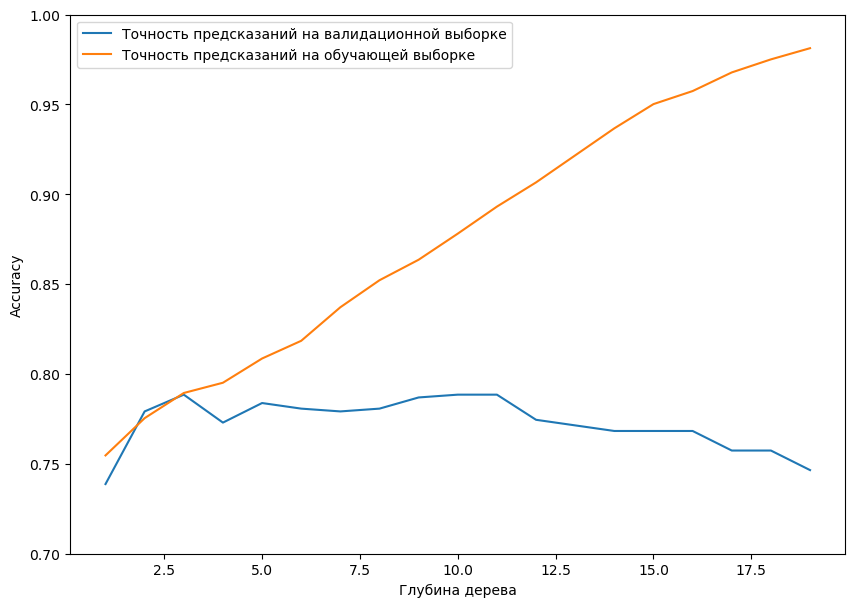

In [12]:
acc_valid = [] # сюда записывается accuracy по валидационной
acc_train = [] # сюда записывается accuracy по обучающей

depth_ = 20

for depth in range(1, depth_):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    
    predictions_valid = model_tree.predict(features_valid)
    predictions_train = model_tree.predict(features_train)
    
#     собираем результаты в списки
    acc_valid.append(accuracy_score(target_valid, predictions_valid))   
    acc_train.append(accuracy_score(target_train, predictions_train))   
    
    
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('')

# строи по спискам графики
ax.plot(np.arange(1, depth_), acc_valid, )
ax.plot(np.arange(1, depth_), acc_train)

ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy')

ax.legend(['Точность предсказаний на валидационной выборке', 'Точность предсказаний на обучающей выборке'])

plt.ylim(0.7, 1);  

In [13]:
best_model = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model 
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print(' ')
print(best_model.get_params())

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}


Получается лучшая модель с глубиной дерева - 3, c accuracy на валидационной выборке = 0.788

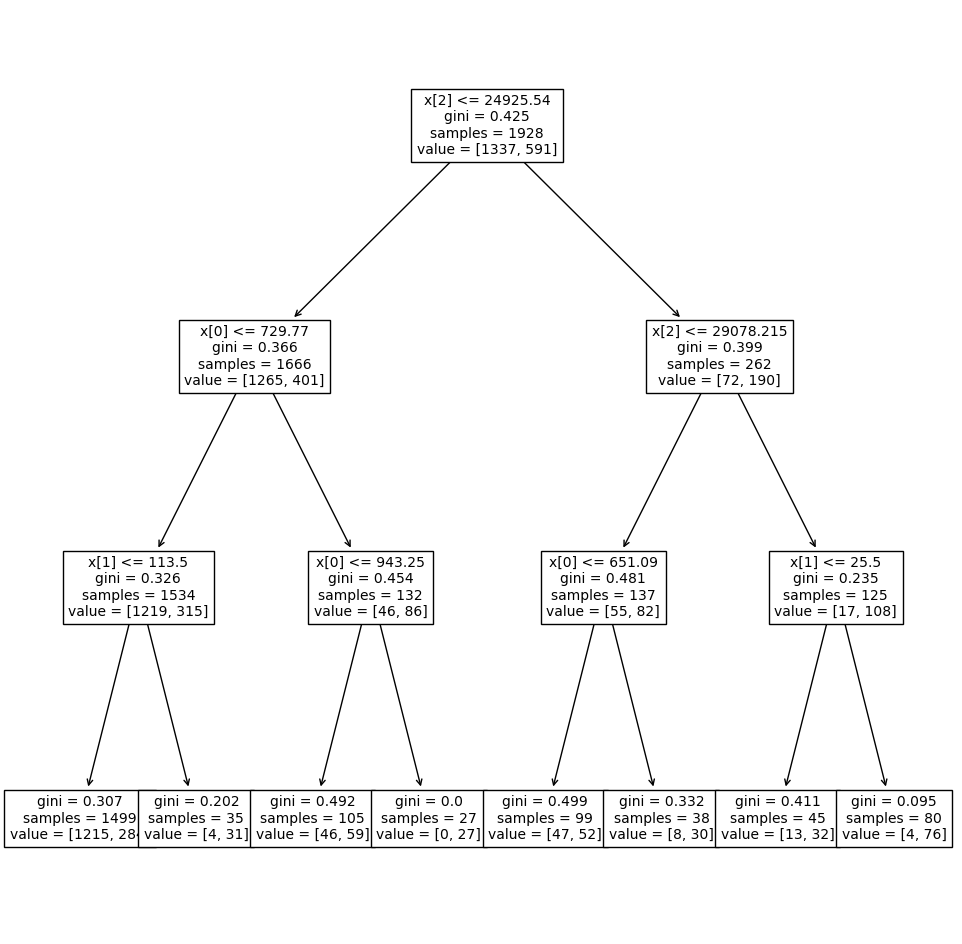

In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3) 
model = model.fit(features_train, target_train)

plt.figure(figsize=(12,12))
tree.plot_tree(model, fontsize=10)

plt.show()

**Случайный лес**  
Перейдем к случайному лесу, он помогает улучшить результат предсказания и избежать переобучения.

In [18]:
%%time
best_model = None
best_result = 0
for est in range(1, 20):
    model = RandomForestClassifier(random_state=12345, criterion='entropy', n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model 
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print(' ')
print(best_model.get_params())

Accuracy наилучшей модели на валидационной выборке: 0.80248833592535
 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 12, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
CPU times: total: 1.12 s
Wall time: 1.15 s


Получается, что самая лучшаю модель с числом деревьев 12 на валидационной выборке с accuracy = 0,80, с критерием энтропии. 

**Логиcтическая регрессия**

In [19]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid) 
print("Accuracy на валидационной выборке:", result)


Accuracy на валидационной выборке: 0.7076205287713841


In [20]:
model = LogisticRegression(random_state=12345, solver='newton-cg', max_iter=100)
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid) 
print("Accuracy на валидационной выборке:", result)

Accuracy на валидационной выборке: 0.744945567651633


## Проверьте модель на тестовой выборке

Лучшая модель - случайный лес. Посмотрим на степень переобучения:

In [28]:
model = RandomForestClassifier(random_state=12345, n_estimators=17, criterion='entropy')
model.fit(features_train, target_train)

valid_predictions = model.predict(features_valid)
test_predictions = model.predict(features_test)
print("Accuracy")
print("Валидационная выборка:", accuracy_score(target_valid, valid_predictions)) 
print("Тестовая выборка:", accuracy_score(target_test, test_predictions))

Accuracy
Валидационная выборка: 0.7993779160186625
Тестовая выборка: 0.7978227060653188


Качество модели на тестовой и валидационой выборке практически одинаковая, что говорит о том, что модель не переобучена.

Обучим модель с выбранными гиперпараметрами на тренировочной + валидационной выборке. Так как чем больше данных, тем можель лучше может обучиться. Дообученную модель проверим на тесте. 

In [22]:
df_combine = pd.concat([data_train, data_valid], axis=0, ignore_index=True)
features = df_combine.drop(['calls', 'is_ultra'], axis=1)
target = df_combine['is_ultra']
print(features.shape)
print(target.shape)

(2571, 3)
(2571,)


In [29]:
model = RandomForestClassifier(random_state=12345, n_estimators=17, criterion='entropy') 
model.fit(features, target)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print(accuracy)

0.807153965785381


In [31]:
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
print("Тренировочная + валидационная выборка:", accuracy) 
print("Тестовая выборка:", accuracy_score(target_test, test_predictions))

Тренировочная + валидационная выборка: 0.807153965785381
Тестовая выборка: 0.7978227060653188


Качество модели, обученной на тренировочной + валидационной выборке, улучшилось. 

Получается лучшая модель - случайный лес, судя по accuracy.

## (бонус) Проверьте модели на адекватность

 Точность (англ. precision) показывает, какая доля объектов, отмеченных моделью как тариф ultra, действительно являются ultra (ответ 1). Надо преминить precision_score().   
Так же сравнивайть модель со случайной, так можно оценить её адекватность, или проверить на вменяемость (англ. sanity check).

In [34]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)
dummy_clf.fit(features_train, target_train)
predictions = dummy_clf.predict(features_test)
accuracy = dummy_clf.score(features_test, target_test)
#print(predictions)
print(accuracy)

0.6920684292379471


Сравнивая accuracy моей модели 0.8>0.69 - значит можель адеквантая.

## Вывод 
- Загрузилали исходный датасет, провали минимальный анализ данных на наличие дубликатов, пропущенных значений и т.д- .
Выполаили разделение исходных данных на обучающую, валидационную и тестовую выбо ии 60/20/20- Вее выдаелил признаки для моделей и обучили моде- ли.
Выбрали модель с самым высоким уровнем Accuracy и провели сравнение качества на тестовой выб Сравнила качество модели, обучив ее на валидационой + тренировочной выборке. 
- Проверила наилучшую модель на адекватность.о- Лзала лучшее значение Accuracy равн0 показала модель случайного лесае 0.81., т.е. 8 из 10 правильных о. А значит мтов. Модель нам подходит.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
